# Identifying Entities in Healthcare Data

## Workspace set up: Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from nltk import FreqDist
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

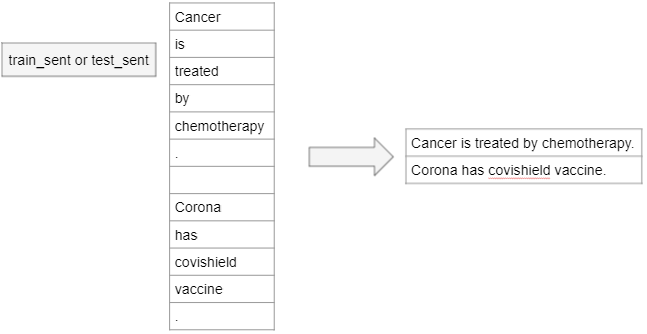

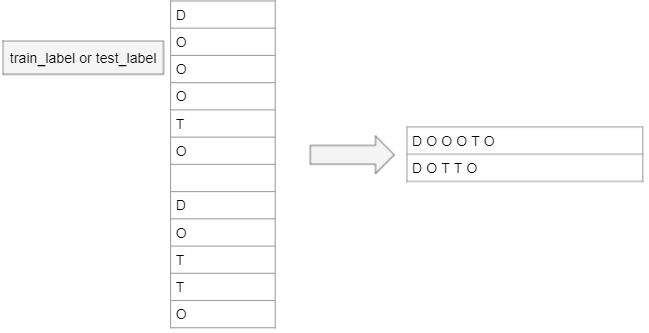

In [3]:
with open('train_sent', 'r') as train_sent_file:
  train_sentences = train_sent_file.readlines()

with open('train_label', 'r') as train_labels_file:
  train_labels = train_labels_file.readlines()

with open('test_sent', 'r') as test_sent_file:
  test_sentences = test_sent_file.readlines()

with open('test_label', 'r') as test_labels_file:
  test_labels = test_labels_file.readlines()

In [4]:
def create_sentence(doc):
    sents = []
    sent = []
    for d in doc:
        if d != '\n':
            word = d.replace('\n','')
#             word = word.replace('``','')
#             word = word.replace('\'\'','')
            # word = word.lower()
            sent.append(word)
        else:
            sents.append(' '.join(sent))
            sent = []
    return sents
            

In [5]:
train_sents_list = create_sentence(train_sentences)
train_labels_list = create_sentence(train_labels)
test_sents_list = create_sentence(test_sentences)
test_labels_list = create_sentence(test_labels)


In [6]:
train_sents_list[0:5]

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )',
 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )',
 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )',
 "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )",
 "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]

In [7]:
train_labels_list[0:5]

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O']

### Count the number of sentences in the processed train and test dataset 

In [8]:
print('Train sentence list - ',len(train_sents_list))

print('Test sentence list - ',len(test_sents_list))

Train sentence list -  2599
Test sentence list -  1056


### Count the number of lines of labels in the processed train and test dataset.

In [9]:
print('Train label list - ',len(train_labels_list))

print('Test label list - ',len(test_labels_list))

Train label list -  2599
Test label list -  1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [10]:
# Combining train and test sentence to find frequency of words
word_list = train_sents_list + test_sents_list

In [11]:
n_freq =[]
for sent in word_list:
    tokens = model(sent)
    
    noun_pronoun = [token.text for token in tokens if token.pos_ in ('NOUN', 'PROPN') ]
    n_freq.extend(noun_pronoun)

print(pd.DataFrame(n_freq).value_counts())

patients            492
treatment           281
%                   247
cancer              200
therapy             175
                   ... 
fungicide             1
Minimal               1
Mikrozirkulation      1
fÃƒ1/4r               1
electrotherapy        1
Name: count, Length: 6431, dtype: int64


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [12]:
print(pd.DataFrame(n_freq).value_counts().head(25))

patients        492
treatment       281
%               247
cancer          200
therapy         175
study           154
disease         142
cell            140
lung            116
group            94
chemotherapy     88
gene             87
effects          85
results          79
women            77
use              74
TO_SEE           74
cases            71
surgery          71
risk             71
analysis         70
rate             67
response         66
survival         65
children         64
Name: count, dtype: int64


[('patients', 492), ('treatment', 281), ('%', 247), ('cancer', 200), ('therapy', 175), ('study', 154), ('disease', 142), ('cell', 140), ('lung', 116), ('group', 94), ('chemotherapy', 88), ('gene', 87), ('effects', 85), ('results', 79), ('women', 77), ('use', 74), ('TO_SEE', 74), ('risk', 71), ('cases', 71), ('surgery', 71), ('analysis', 70), ('rate', 67), ('response', 66), ('survival', 65), ('children', 64)]


<Axes: xlabel='0', ylabel='1'>

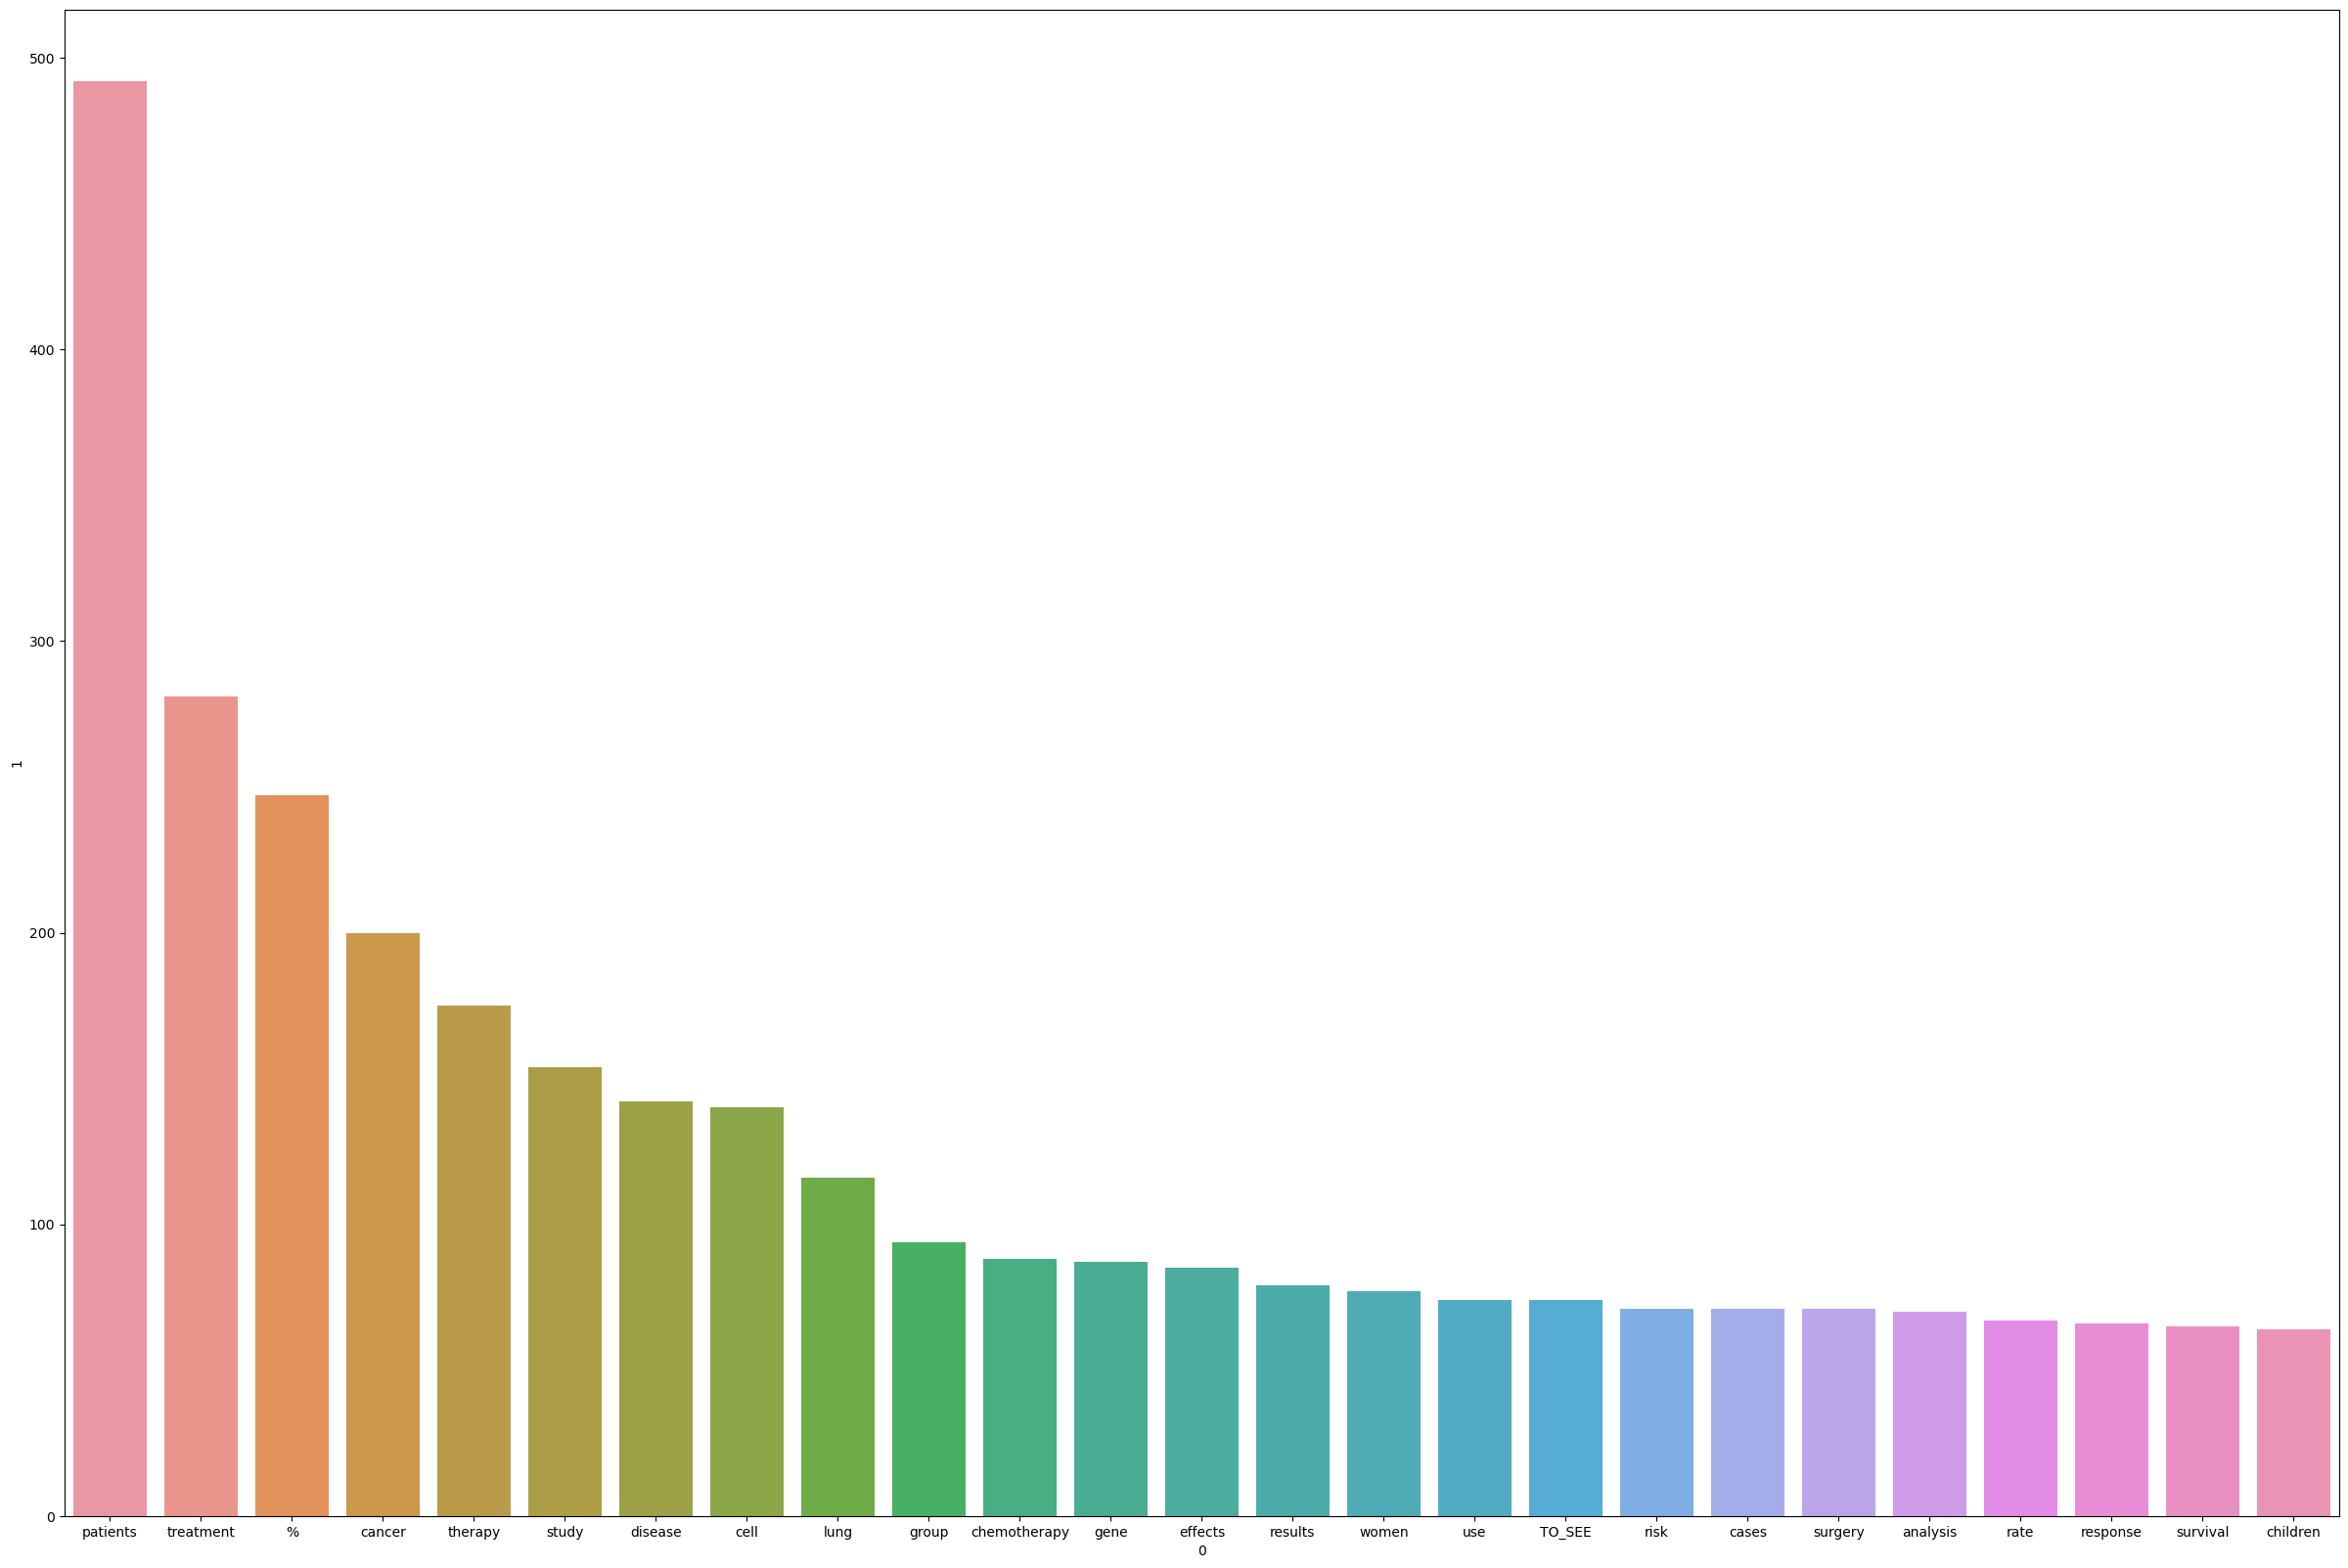

In [13]:
def plot_word_frequency(words, top_n=10):
    word_freq = FreqDist(words)
    print(word_freq.most_common(top_n))
    plt.figure(figsize=(30, 20))
    values = pd.DataFrame([element for element in word_freq.most_common(top_n)])
    plot = sns.barplot(x=0, y=1, data=values)
    return plot

plot_word_frequency(n_freq, 25)

## Defining features for CRF





In [14]:
# Let's define the features to get the feature value for one word.
sent = train_sents_list[6]
sent_list = sent.split()
position = 7

word = sent_list[position]

print(sent)

print('POS of word in isolation ')
print('word - ', word, '\t\t pos - ', model(word)[0].pos_)
print('\n\n')
print('POS of a word in a sentence')

for token in model(sent):
    print('word - ', token.text, '\t\t pos - ', token.pos_)

print('\n\n')
print('POS of ', word, 'in the sentence')

for token in model(sent):    
    if token.text == word:
        print('word - ', token.text, '\t\t pos - ', token.pos_)
        break

In the third trimester , the amniotic fluid index ( AFI ) may be affected by maternal fluid status
POS of word in isolation 
word -  fluid 		 pos -  ADJ



POS of a word in a sentence
word -  In 		 pos -  ADP
word -  the 		 pos -  DET
word -  third 		 pos -  ADJ
word -  trimester 		 pos -  NOUN
word -  , 		 pos -  PUNCT
word -  the 		 pos -  DET
word -  amniotic 		 pos -  ADJ
word -  fluid 		 pos -  NOUN
word -  index 		 pos -  NOUN
word -  ( 		 pos -  PUNCT
word -  AFI 		 pos -  PROPN
word -  ) 		 pos -  PUNCT
word -  may 		 pos -  AUX
word -  be 		 pos -  AUX
word -  affected 		 pos -  VERB
word -  by 		 pos -  ADP
word -  maternal 		 pos -  ADJ
word -  fluid 		 pos -  NOUN
word -  status 		 pos -  NOUN



POS of  fluid in the sentence
word -  fluid 		 pos -  NOUN


## Getting the features

### Write a code/function to get the features for a sentence

In [15]:
# Function to obtain contextual PoS tagger.
def contextual_pos_tagger(sent_list,position):
    '''Obtaining PoS tag for individual word with sentence context in-tact. 
       If the PoS tag is obtained for a word individually, it may not capture the context of use in the sentence and may assign the incorrect PoS tag.'''

    sentence = " ".join(sent_list)          # Sentence needs to be in string format to process it with spacy model. List of words won't work.
    posit = 0                               # Initialising variable to record position of word in joined sentence to compare with the position of the word under considertion.
    for token in model(sentence):
        postag = token.pos_
        if (token.text == word) and (posit == position):
            break
        posit += 1
    return postag

In [16]:
# Write a code to get features for a sentence.
# Define the features to get the feature values for one word.
def getFeaturesForOneWord(sent_list, position):
    word = sent_list[position]
    
    # Obtaining features for current word
    features = [
        'word.lower=' + word.lower(),                                   # serves as word id
        'word.postag=' + contextual_pos_tagger(sent_list, position),    # PoS tag of current word
        'word[-3:]=' + word[-3:],                                       # last three characters
        'word[-2:]=' + word[-2:],                                       # last two characters
        'word.isupper=%s' % word.isupper(),                             # is the word in all uppercase
        'word.isdigit=%s' % word.isdigit(),                             # is the word a number
        'words.startsWithCapital=%s' % word[0].isupper()                # is the word starting with a capital letter
    ]

    if(position > 0):
        prev_word = sent_list[position-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(),                               # previous word
        'prev_word.postag=' + contextual_pos_tagger(sent_list, position - 1), # PoS tag of previous word
        'prev_word.isupper=%s' % prev_word.isupper(),                         # is the previous word in all uppercase
        'prev_word.isdigit=%s' % prev_word.isdigit(),                         # is the previous word a number
        'prev_words.startsWithCapital=%s' % prev_word[0].isupper()            # is the previous word starting with a capital letter
        ])
    else:
        features.append('BEG')                                                # feature to track begin of sentence 

    if(position == len(sent_list)-1):
        features.append('END')                                                # feature to track end of sentence

    return features

In [17]:
def getFeatureForOneSentence(sentence):
    sent_list = sentence.split()
    return [getFeaturesForOneWord(sent_list, i) for i in range(len(sent_list))]

In [18]:
example_sent = train_sents_list[8]
features = getFeatureForOneSentence(example_sent)
features[0]

['word.lower=from',
 'word.postag=ADJ',
 'word[-3:]=rom',
 'word[-2:]=om',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=True',
 'BEG']

In [19]:
features[9]

['word.lower=during',
 'word.postag=ADJ',
 'word[-3:]=ing',
 'word[-2:]=ng',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'prev_word.lower=,',
 'prev_word.postag=ADJ',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_words.startsWithCapital=False']

### Write a code/function to get the labels of a sentence

In [20]:
# Write a code to get the labels for a sentence.
def getLabelsOfSentence(label_list):
    return label_list.split()


In [21]:
example_label = train_labels_list[4]
print(getLabelsOfSentence(example_label))

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [22]:
X_train = [getFeatureForOneSentence(sent) for sent in train_sents_list]
X_test = [getFeatureForOneSentence(sent) for sent in test_sents_list]

### Define the labels as the target variable for test and the train dataset

In [23]:
y_train = [getLabelsOfSentence(label) for label in train_labels_list]
y_test = [getLabelsOfSentence(label) for label in test_labels_list]

## Build the CRF Model

In [24]:
pip install -U sklearn-crfsuite

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [25]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=300, keep_tempfiles=False)
try:
    crf.fit(X_train, y_train)
except AttributeError:
    pass

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [26]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [27]:
metrics.flat_f1_score(y_test, y_pred, average='weighted')

0.9081808858227082

## Model 2 - adding more features

In [28]:
# Define the features to get the feature values for one word.
def getFeaturesForOneWord_Model2(sent_list, position, pos_tags, deptags):
    word = sent_list[position]
    
    # Obtaining features for current word
    features = [
        'word.lower=' + word.lower(),                                   # serves as word id
        'word.postag=' + contextual_pos_tagger(sent_list, position),    # PoS tag of current word
        'word[-3:]=' + word[-3:],                                       # last three characters
        'word[-2:]=' + word[-2:],                                       # last two characters
        'word.isupper=%s' % word.isupper(),                             # is the word in all uppercase
        'word.isdigit=%s' % word.isdigit(),                             # is the word a number
        'words.startsWithCapital=%s' % word[0].isupper(),                # is the word starting with a capital letter
        'word.pos=' + pos_tags[position], # adding POS tag here
        'word.dep_=' + deptags[position] # adding DEP tag here
    ]

    if(position > 0):
        prev_word = sent_list[position-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(),                               # previous word
        'prev_word.postag=' + contextual_pos_tagger(sent_list, position - 1), # PoS tag of previous word
        'prev_word.isupper=%s' % prev_word.isupper(),                         # is the previous word in all uppercase
        'prev_word.isdigit=%s' % prev_word.isdigit(),                         # is the previous word a number
        'prev_words.startsWithCapital=%s' % prev_word[0].isupper(),            # is the previous word starting with a capital
        'prev_word.pos=' + pos_tags[position-1], # adding POS tag here
        'prev_word.dep_=' + deptags[position-1] # adding DEP tag hereletter
        ])
    else:
        features.append('BEG')                                                # feature to track begin of sentence 

    if(position == len(sent_list)-1):
        features.append('END')                                                # feature to track end of sentence

    return features

In [29]:
def getFeatureForOneSentence_Model2(sentence):
    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []
    
    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep
    
    sentence_list = sentence.split()
    return [getFeaturesForOneWord_Model2(sentence_list, pos, postags, deptags) for pos in range(len(sentence_list))]

In [30]:
X_train = [getFeatureForOneSentence_Model2(sent) for sent in train_sents_list]
X_test = [getFeatureForOneSentence_Model2(sent) for sent in test_sents_list]

In [31]:
# Build the CRF model.
crf_2 = sklearn_crfsuite.CRF(max_iterations=300, keep_tempfiles=False)
try:
    crf_2.fit(X_train, y_train)
except AttributeError:
    pass

In [32]:
y_pred_2 = crf_2.predict(X_test)

In [33]:
print("Model 2 F1 Score - ",metrics.flat_f1_score(y_test, y_pred_2, average='weighted'))

Model 2 F1 Score -  0.9136604755014552


## Model 3 Updating CRF Parameters

In [34]:
# Build the CRF 2odel.
crf_3 = sklearn_crfsuite.CRF(max_iterations=300, algorithm='lbfgs', c1=0.05, c2=0.05)
try:
    crf_3.fit(X_train, y_train)
except AttributeError:
    pass

In [35]:
y_pred_3 = crf_3.predict(X_test)

In [36]:
print("Model 3 F1 Score - ",metrics.flat_f1_score(y_test, y_pred_3, average='weighted'))

Model 3 F1 Score -  0.923227739563646


## F1 score of all models

In [37]:
print("Model 1 F1 Score - ",metrics.flat_f1_score(y_test, y_pred, average='weighted'))
print("Model 2 F1 Score - ",metrics.flat_f1_score(y_test, y_pred_2, average='weighted'))
print("Model 3 F1 Score - ",metrics.flat_f1_score(y_test, y_pred_3, average='weighted'))

Model 1 F1 Score -  0.9081808858227082
Model 2 F1 Score -  0.9136604755014552
Model 3 F1 Score -  0.923227739563646


## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

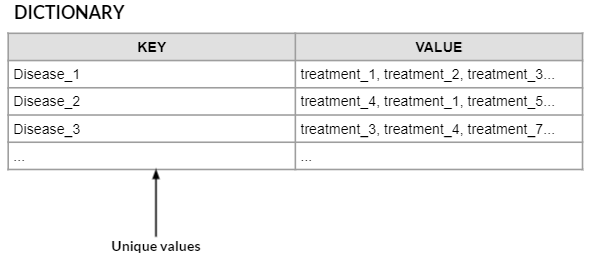

In [38]:
def fetch_disease_treatment(X_test, y_pred):
    disease_treatment ={}
    disease =[]
    for i in range(len(y_pred)):
        treatment = []
        disease = []
        for j in range(len(y_pred[i])):
            if y_pred[i][j] == 'T':
                treatment.append(X_test[i][j][0].split('=')[1] )

            if y_pred[i][j] == 'D':
                disease.append(X_test[i][j][0].split('=')[1])

        key_disease = " ".join(disease)
        value_treatment = " ".join(treatment)
        if len(disease) !=0 and len(treatment)!=0:        
            if disease_treatment.get(key_disease) != None:
                disease_treatment.get(key_disease).append(value_treatment)
            else:
                disease_treatment[key_disease] = [value_treatment]
    
    return disease_treatment

In [39]:
disease_treatment_pred = fetch_disease_treatment(X_test, y_pred_2)
disease_treatment_pred

{'hereditary retinoblastoma': ['radiotherapy'],
 'epilepsy': ['methylphenidate'],
 'unstable angina or non-q-wave myocardial infarction': ['roxithromycin'],
 'coronary-artery disease': ['antichlamydial antibiotics'],
 'primary pulmonary hypertension ( pph )': ['fenfluramines'],
 'essential hypertension': ['moxonidine'],
 "early parkinson 's disease": ['ropinirole monotherapy'],
 'sore throat': ['antibiotics'],
 "abdominal tuberculosis crohn 's disease": ['steroids'],
 'female stress urinary incontinence': ['surgical treatment'],
 'stress urinary incontinence': ['therapy'],
 'preeclampsia ( proteinuric hypertension )': ['intrauterine insemination with donor sperm versus intrauterine insemination'],
 'severe acquired hyperammonemia cancer': ['organ transplantation and chemotherapy'],
 'major pulmonary embolism': ['thrombolytic treatment'],
 'malignant pleural mesothelioma': ['thoracotomy , radiotherapy , and chemotherapy'],
 'pulmonary symptoms attributable': ['chemotherapy'],
 'non-obst

In [40]:
print("Total number of diseases detected - ",len(disease_treatment_pred))

Total number of diseases detected -  119


In [41]:
search_item = 'hereditary retinoblastoma'
treatments = disease_treatment_pred[search_item]
print("Treatments for '{0}' is/are ".format(search_item), end = "")
for i in range(len(treatments)-1):
    print("'{}'".format(treatments[i]),",", end="")
print("'{}'".format(treatments[-1]))

Treatments for 'hereditary retinoblastoma' is/are 'radiotherapy'


In [53]:
data = {
    'Model': [
                """Model 1""", 
                """Model 2 - with pos and def features""", 
                """Model 3 - max_iterations=300, algorithm='lbfgs', c1=0.05, c2=0.05"""
            ],        
    "F1 Score" : [
                metrics.flat_f1_score(y_test, y_pred, average='weighted'),
                metrics.flat_f1_score(y_test, y_pred_2, average='weighted'),
                metrics.flat_f1_score(y_test, y_pred_3, average='weighted')
            ],
    'Disease Database Count': [
                    len(fetch_disease_treatment(X_test, y_pred)), 
                    len(fetch_disease_treatment(X_test, y_pred_2)), 
                    len(fetch_disease_treatment(X_test, y_pred_3))
        ]
}


In [54]:

# Creating dataframe out of the dictionary of disease and treatment
df1=pd.DataFrame(data)
df1.style.set_properties(**{'text-align': 'left'})
display(df1)

,Model,F1 Score,Disease Database Count
0,Model 1,0.908181,101
1,Model 2 - with pos and def features,0.913660,119
2,"Model 3 - max_iterations=300, algorithm='lbfgs', c1=0.05, c2=0.05",0.923228,168


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [55]:
search_item = 'hereditary retinoblastoma'
treatments = disease_treatment_pred[search_item]
print("Treatments for '{0}' is/are ".format(search_item), end = "")
for i in range(len(treatments)-1):
    print("'{}'".format(treatments[i]),",", end="")
print("'{}'".format(treatments[-1]))

Treatments for 'hereditary retinoblastoma' is/are 'radiotherapy'
